In [121]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw
from sksurv.util import Surv

from sklearn.impute import SimpleImputer

import xgboost as xgb
import lightgbm as lgb

# EDA and Data Preprocessing

In [122]:
# Clinical data
c_train = pd.read_csv("./clinical_train.csv")
c_test = pd.read_csv("./clinical_test.csv")

# Molecular data
m_train = pd.read_csv("./molecular_train.csv")
m_test = pd.read_csv("./molecular_test.csv")

# Target data
target_train = pd.read_csv("target_train.csv")


## Clinical Data Analysis

In [123]:
# Preview
c_train.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [124]:
# Checking how much data is missing
print("Rows, columns: ", c_train.shape)
c_train.isnull().sum()

Rows, columns:  (3323, 9)


ID                0
CENTER            0
BM_BLAST        109
WBC             272
ANC             193
MONOCYTES       601
HB              110
PLT             124
CYTOGENETICS    387
dtype: int64

### There is quite a significant sum of missing data which could be useful if imputed but first we will explore models which don't use imputation.
### For now we use a simple imputer.

#### First we should visualise the distribution and shape of the data

In [125]:
# Drop NaN rows
target_train.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)

# verifying data types (should be boolean and numeric)
target_train[['OS_YEARS', 'OS_STATUS']].dtypes

target_train['OS_STATUS'] = target_train['OS_STATUS'].astype(bool)

features = ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT']
target = ['OS_YEARS', 'OS_STATUS']

# Create survival data format
X = c_train.loc[c_train['ID'].isin(target_train['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_train)


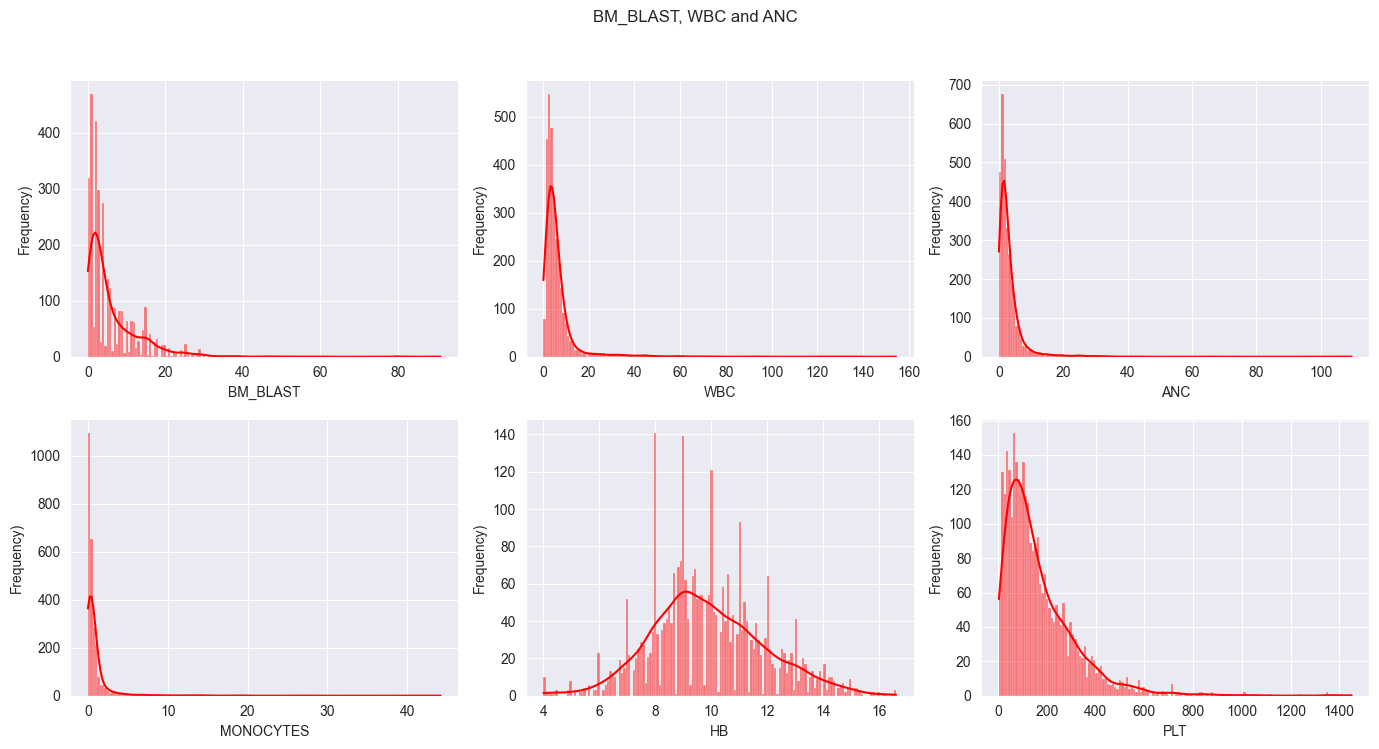

In [150]:
# BM_BLAST, WBC and ANC
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle("BM_BLAST, WBC and ANC")

axes = axes.flatten()

for i, feature in enumerate(features):  # first 3 features
    ax = axes[i]
    sns.histplot(X[feature], ax=ax, bins=150, kde=True, color="red")
    ax.set_xlabel(f"{feature}")
    ax.set_ylabel("Frequency)")

plt.tight_layout(rect=[0, 0.05, 1, 0.95]);
plt.show();

# Imputing clinical data with SimpleImputer
## 1. Train-test split
## 2. SimpleImputer


In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)  # 35% test split

In [128]:
imputer = SimpleImputer(strategy="median")
X_train[features] = imputer.fit_transform(X_train[features])
X_test[features] = imputer.transform(X_test[features])

In [149]:
# Preparing data for XGBoost model
X_train_xgb = X_train
y_train_trans = y_train['OS_YEARS']

y_test_trans = y_test['OS_YEARS']

# Creating D-matrices for survival model in XGB
dtrain = xgb.DMatrix(X_train, label=y_train_trans)
dtest = xgb.DMatrix(X_test, label=y_test_trans)

lower_bound = np.where(y_test_trans == y_test_trans.min())[0]
dtrain.set_float_info("label_lower_bound", lower_bound)

# Creating XGBoost survival model
params = {'verbosity': 0,
          'objective': 'survival:aft',
          'eval_metric': 'aft-nloglik',
          'alpha': 0.05}

watchlist = [(dtrain, 'train'), (dtest, 'eval')]
xgbr = xgb.train(params, dtrain, evals=watchlist,
                 num_boost_round=1000, early_stopping_rounds=50)

(2062,)
(1111, 6)


XGBoostError: [11:43:25] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\aft_obj.cu:74: Check failed: info.labels_lower_bound_.Size() == ndata (0 vs. 2062) : 

## Molecular Data Analysis


In [7]:
# Preview
m_train.head()

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0


In [79]:
m_train.dtypes

ID                 object
CHR                object
START             float64
END               float64
REF                object
ALT                object
GENE               object
PROTEIN_CHANGE     object
EFFECT             object
VAF               float64
DEPTH             float64
dtype: object

# Training the model
